In [126]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from MyModel import *
from prep_image import prep_im_and_mask
import os
import matplotlib.pyplot as plt

In [59]:
df_features = pd.read_csv('feature_data.csv')
df = pd.read_csv('metadata_withmasks.csv')

df = df[df['mask']==1]
labels = df['diagnostic']

In [60]:
df_features.iloc[[69]]

,patient_id,img_id,assymmetry,red_var,green_var,blue_var,hue_var,sat_var,val_var,dom_hue,dom_sat,dom_val,compactness,convexity
69,PAT_1461,PAT_1461_1600_867.png,0.0802,0.004887,0.005123,0.006126,0.0953,0.005722,0.00474,0.05557,0.066,0.5337,0.722,0.064


In [61]:
feature_names = ['assymmetry', 'red_var', 'green_var', 'blue_var', \
     'hue_var', 'sat_var', 'val_var', 'dom_hue', 'dom_sat', 'dom_val', \
     'compactness', 'convexity']

In [62]:
X=df_features
y = (labels == 'BCC') | (labels == 'SCC') | (labels == 'MEL')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 41, stratify = y)

In [63]:
X_train_transformed = apply_pca(X_train[feature_names])
X_test_transformed = apply_pca(X_test[feature_names])

C:\Users\idawe\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
C:\Users\idawe\anaconda3\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator PCA from version 1.2.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [64]:
knn = KNeighborsClassifier(3)

In [65]:
knn.fit(X_train_transformed,y_train)

KNeighborsClassifier(n_neighbors=3)

In [66]:
results_pca = knn.predict(X_test_transformed)

In [69]:
knn.fit(X_train[feature_names],y_train)
results = knn.predict(X_test[feature_names])

In [95]:
predictions = pd.DataFrame({'Image ID':X_test['img_id'].tolist(), 'Results':results, 'Results PCA':results_pca, 'True':y_test})

In [51]:
sum(y_test == results)

81

In [120]:
im, mask = prep_im_and_mask('PAT_1418_1447_360.png','images'+os.sep,'images_masks'+os.sep)

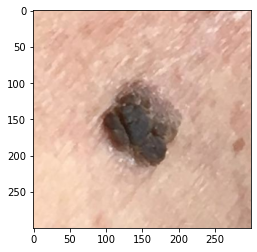

In [121]:
plt.imshow(im)

In [99]:
mask = predictions['Results PCA'] == predictions['True']
predictions[mask]

,Image ID,Results,Results PCA,True
1459,PAT_1418_1447_334.png,False,False,False
942,PAT_1780_3380_542.png,False,False,False
2253,PAT_1392_1352_828.png,False,False,False
1519,PAT_612_1163_833.png,True,True,True
1582,PAT_1946_3924_627.png,False,False,False
...,...,...,...,...
424,PAT_1393_1356_371.png,False,False,False
422,PAT_1109_436_141.png,False,False,False
1844,PAT_333_702_840.png,True,True,True
495,PAT_1350_1230_878.png,False,False,False


In [104]:
colors = {'MEL':'red', 'BCC':'orange','SCC':'purple','SEK':'blue','NEV':'green','ACK':'yellow'}

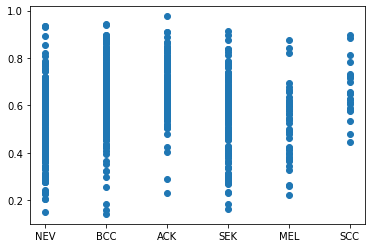

In [114]:
plt.scatter(labels, df_features['dom_val'])

In [117]:
from color import get_rgb_means, slic_segmentation

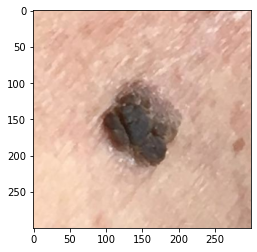

In [116]:
plt.imshow(im)

In [123]:
segments = slic_segmentation(im,mask)

In [124]:
print(get_rgb_means(im, segments))

[array([0.47319782, 0.3738899 , 0.33499122], dtype=float32), array([0.45170256, 0.34493807, 0.30394828], dtype=float32), array([0.33659783, 0.2930629 , 0.26984933], dtype=float32), array([0.34766707, 0.20494938, 0.15840426], dtype=float32), array([0.5457229 , 0.45186356, 0.40130326], dtype=float32), array([0.20632929, 0.14469673, 0.11434568], dtype=float32), array([0.27812463, 0.24736522, 0.22790056], dtype=float32), array([0.30986738, 0.28829253, 0.28128156], dtype=float32), array([0.27747294, 0.2602179 , 0.2591284 ], dtype=float32), array([0.29213095, 0.23204029, 0.1917118 ], dtype=float32), array([0.39265382, 0.31670558, 0.27939844], dtype=float32), array([0.44194597, 0.32894787, 0.28046748], dtype=float32), array([0.5430975 , 0.42915258, 0.36180806], dtype=float32), array([0.36227578, 0.295921  , 0.26752323], dtype=float32), array([0.31837773, 0.2721744 , 0.25705874], dtype=float32)]


In [127]:
np.unique(segments)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [143]:
rgb_mean_lesion = np.mean(get_rgb_means(im, segments),axis=0)

In [137]:
segment = im.copy()
segment[segments != 0] = 0

In [144]:
rgb_mean_skin = np.mean(segment, axis=(0,1), where=(segment!=0))

In [153]:
F1, F2, F3 = rgb_mean_lesion/sum(rgb_mean_lesion)
F10, F11, F12 =  rgb_mean_lesion-rgb_mean_skin

0.39693698

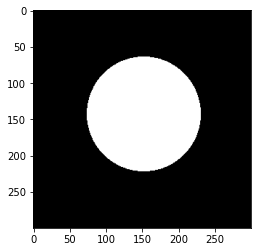

In [210]:
circle = plt.imread('mycircle.png')
plt.imshow(circle)

In [211]:
circle = circle.astype(int)
circle = circle.astype(int)
circle = rgb2gray(circle*256)
np.unique(circle)

array([0.0000000e+00, 1.1920929e-07])

In [212]:
np.shape(circle)

(300, 300)

In [192]:
from skimage.color import rgb2gray
rgb2gray(circle)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

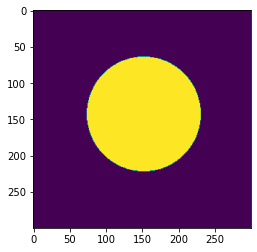

In [213]:
plt.imshow(circle)

In [203]:
from asymmetry import mean_asymmetry
from compactness import compactness_score
from convexity import convexity_score

In [214]:
mean_asymmetry(circle)

4503460.926143334

ValueError: the input array must have size 3 along `channel_axis`, got (300, 300)

In [193]:
col_sums = np.sum(circle, axis=0)

In [194]:
active_cols = []
for index, col_sum in enumerate(col_sums):
    if col_sum != 0:
        active_cols.append(index)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [172]:
from scipy.ndimage import rotate

In [186]:
rotated_circle = rotate(circle, 10)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


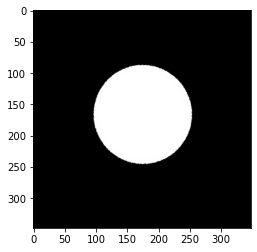

In [187]:
plt.imshow(rotated_circle)

In [188]:
np.unique(rotated_circle)

array([-0.19742809, -0.1942509 , -0.19200979, ...,  1.1939403 ,
        1.2024344 ,  1.2047399 ], dtype=float32)

In [189]:
convexity_score(circle)

0.256

In [190]:
compactness_score(circle)

RuntimeError: structure and input must have same dimensionality